## Data processing

In [1]:
import numpy as np
import pandas as pd

In [2]:
X=pd.read_csv("X_weekly.csv")

In [3]:
y=pd.read_csv("SP500_weekly.csv")

In [4]:
X_raw=X.loc[:,'co':'dia']
X_raw.head()

,co,http,market,amp,year,via,stock,fed,today,week,...,safe,washington,self,complet,date,room,featur,weight,bounc,dia
0,21,21,6,5,11,3,9,0,14,6,...,0,0,0,0,0,0,0,0,0,0
1,17,11,0,3,4,0,0,0,13,2,...,0,0,0,3,0,0,0,0,0,0
2,38,38,3,12,3,2,6,0,0,5,...,3,0,0,0,0,0,0,0,0,0
3,32,23,0,20,6,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
4,39,39,3,22,6,3,6,0,5,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_raw=y.loc[:,"y"]
y_raw.head()

0    0
1    1
2    0
3    1
4    0
Name: y, dtype: int64

In [6]:
base=np.sum(y_raw)/len(y_raw)
base

0.10404624277456648

Our base rate is about 10.40%.

In [7]:
#split our dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_raw, y_raw, test_size=0.3, random_state=1)

In [8]:
len(y_test)

52

In [9]:
y_test2=np.array(y_test.copy())

In [10]:
np.sum(y_test)

8

Note that there are only 8 major drops in the test set (52 samples).

## Logistic regression 

We first use Logistic regression with no scaling.

In [106]:
from sklearn.linear_model import LogisticRegression

In [11]:
lmfit = LogisticRegression(C=100000).fit(X_train, y_train)

yhat_lm = lmfit.predict(X_test)
np.mean(y_test!=yhat_lm)

0.17307692307692307

In [24]:
prob_lm=lmfit.predict_proba(X_test)[:,1]
prob_rank_lm=np.flip(np.argsort(prob_lm),0)
np.sum(y_test2[prob_rank_lm[:20]])/20

0.25

In [25]:
from sklearn.metrics import roc_auc_score

In [16]:
roc_auc_score(y_test,prob_lm)

0.5909090909090908

Summary: our misclassfication rate is higher than the base rate. But our top 20 prediction is able to catch 5 major drop among the whole 8 major drops in the test set. Compared to our past homework, the roc score is not good.

We now try scaling our samples.

In [12]:
from sklearn.preprocessing import scale

In [13]:
X_train_scale=scale(X_train)
X_test_scale=scale(X_test)

In [19]:
lmfit2 = LogisticRegression(C=100000).fit(X_train_scale, y_train)

yhat_lm2 = lmfit2.predict(X_test_scale)
np.mean(y_test!=yhat_lm2)

0.2692307692307692

In [25]:
prob_lm2=lmfit2.predict_proba(X_test_scale)[:,1]
prob_rank_lm2=np.flip(np.argsort(prob_lm2),0)
np.sum(y_test2[prob_rank_lm2[:20]])/20

0.15

In [21]:
roc_auc_score(y_test,prob_lm2)

0.48579545454545453

Scaling does not help our classification. We have higher misclassification rate, lower ROC, less ability to predict major drop.

We also try scaling using tf-idf.

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer as tt

In [27]:
mytt=tt(use_idf=False)
X_train_scale3=mytt.fit_transform(X_train_scale)
X_test_scale3=mytt.fit_transform(X_test_scale)

In [28]:
lmfit3 = LogisticRegression(C=100000).fit(X_train_scale3, y_train)

yhat_lm3 = lmfit3.predict(X_test_scale3)
np.mean(y_test!=yhat_lm3)

0.19230769230769232

In [29]:
prob_lm3=lmfit3.predict_proba(X_test_scale3)[:,1]
prob_rank_lm3=np.flip(np.argsort(prob_lm3),0)
np.sum(y_test2[prob_rank_lm3[:20]])/20

0.15

In [30]:
roc_auc_score(y_test,prob_lm3)

0.4943181818181818

No huge improvement was seen from scaling.

Now we try GAM. However, GAM does not allow us to use 1000 features due to memory limitation. So we select the most frequent 25 words here.

In [110]:
from pygam import LogisticGAM
from pygam.utils import generate_X_grid

In [111]:
X_train_selected=X_train_scale[:,:25]
X_test_selected=X_test_scale[:,:25]

In [112]:
%%capture
fit = LogisticGAM().gridsearch(X_train_selected, y_train, lam = np.logspace(-2, 1, 30))

100% (30 of 30) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


In [113]:
yhat_gam = fit.predict(X_test_selected)
np.mean(y_test!=yhat_gam)

0.11538461538461539

In [114]:
prob_gam=fit.predict_proba(X_test_selected)
prob_rank_gam=np.flip(np.argsort(prob_gam),0)
np.sum(y_test2[prob_rank_gam[:10]])/10

0.4

In [115]:
roc_auc_score(y_test,prob_gam)

0.6420454545454546

Although we can only select 25 features, GAM shows its power here. Its misclassification rate is 11.54%, roc is 0.6420, a decent result. Surprisingly, its top 10 predictions contain 4 major drops. So, when this model highly suggests a major drop, it is really likely that a major drop will happen.

Finally, let us try regularized logistic regression.

In [38]:
import rpy2
%load_ext rpy2.ipython

In [39]:
%%R -i X_train -i X_test -i y_train -i y_test

X_train_R=as.matrix(X_train)
X_test_R=as.matrix(X_test)
y_train_R=as.matrix(y_train)
y_test_R=as.matrix(y_test)

In [94]:
%%R

library(glmnet)
set.seed(1)

cvlasso_R=cv.glmnet(X_train_R,y_train_R,alpha=1,family="binomial",type.measure="class")
best_lam_lasso=cvlasso_R$lambda.min

lasso_R=glmnet(X_train_R,y_train_R,alpha=1,lambda=best_lam_lasso,family="binomial")
y_pred_test=predict(lasso_R,newx=X_test_R,s=best_lam_lasso,type="class")

In [95]:
%R mean(y_pred_test!=y_test)

array([0.15384615])

In [96]:
%R which(lasso_R$beta!=0)

array([ 72,  92, 139, 325, 446, 451, 490, 528, 563, 597, 606, 772, 780,
       811, 925], dtype=int32)

In [85]:
import pickle

In [86]:
fr = open('selected_wordbag.txt','rb')  
selected_wordbag = pickle.load(fr)
fr.close()

In [87]:
word_list=[72,  92, 139, 325, 446, 451, 490, 528, 563, 597, 606, 772, 780,811, 925]
[selected_wordbag[i-1] for i in word_list]

['gdp',
 'ft',
 'remain',
 'survey',
 'ecb',
 'morganstanley',
 'rel',
 'eagl',
 'june',
 'highlight',
 'slightli',
 'crash',
 'soft',
 'exist',
 'peopleatm']

Some words are the account name, others have some clear meanings. For example, gdp, remain, survey, rely, eagle, june, highlight, slightly, crash, soft, exist.

In [89]:
%R lasso_R$beta[c(72,  92, 139, 325, 446, 451, 490, 528, 563, 597, 606, 772, 780,811, 925)]

array([-0.00311922, -0.00862871, -0.0372262 , -0.03355158, -0.00307578,
        0.08584726, -0.00036143,  0.00410814, -0.00853832, -0.02579761,
       -0.00649731,  0.03951969, -0.06621725, -0.0110836 , -0.01640459])

An interesting thing to notice is that "crash" has the highest positive coefficent, meaning that one more "crash" on twitter will significantly increase the chance of major drop. "soft" has the highest negative coefficient, that might have something to do with a better macroeconomic environment. Notice that we do not consider account name here, e.g. morganstanley. It is actually one account of our tweet library. But it is also interesting that once Morgan Stanley tweets, it is likely that a major drop will happen.

## Decision Tree 

In [116]:
%%capture
from sklearn.ensemble import RandomForestClassifier

We first try with no scaling

In [106]:
fitrf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1).fit(X_train, y_train)

In [107]:
yhat_rf = fitrf.predict(X_test)
np.mean(yhat_rf != y_test)

0.15384615384615385

In [111]:
prob_rf=fitrf.predict_proba(X_test)[:,1]
prob_rank_rf=np.flip(np.argsort(prob_rf),0)
np.sum(y_test2[prob_rank_rf[:20]])/20

0.15

In [112]:
roc_auc_score(y_test,prob_rf)

0.5752840909090909

We have a decent result here. Misclassification rate is 15.38%, top 20 contains 3 major drop, auc score is 0.5753.

We then try with scaling.

In [123]:
fitrf2 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1).fit(X_train_scale, y_train)

In [124]:
yhat_rf2 = fitrf2.predict(X_test_scale)
np.mean(yhat_rf2 != y_test)

0.15384615384615385

In [125]:
prob_rf2=fitrf2.predict_proba(X_test_scale)[:,1]
prob_rank_rf2=np.flip(np.argsort(prob_rf2),0)
np.sum(y_test2[prob_rank_rf2[:10]])/10

0.3

In [126]:
roc_auc_score(y_test,prob_rf2)

0.7230113636363636

Random forest with scaling is better. The top 10 case contains 3 major drops, and the AUC score is 0.7230, a beautiful result.

In [121]:
a = list(zip(X_train.columns, fitrf2.feature_importances_))
a.sort(key=lambda x: x[1], reverse=True)
a[:10]

[('co', 0.029750342579526683),
 ('http', 0.019834001002336947),
 ('continu', 0.013744598203036395),
 ('remain', 0.010282360434386736),
 ('worst', 0.010158297799973369),
 ('market', 0.00930873852182915),
 ('hk', 0.00909891367969841),
 ('morganstanley', 0.008621257224271402),
 ('read', 0.008201861982841122),
 ('today', 0.007131651142763959)]

This is actually what random forest considers to be the most important features. We expect "worst" here, but others do not make much sense...

In [63]:
import matplotlib
import matplotlib.pyplot as plt
from pdpbox import pdp

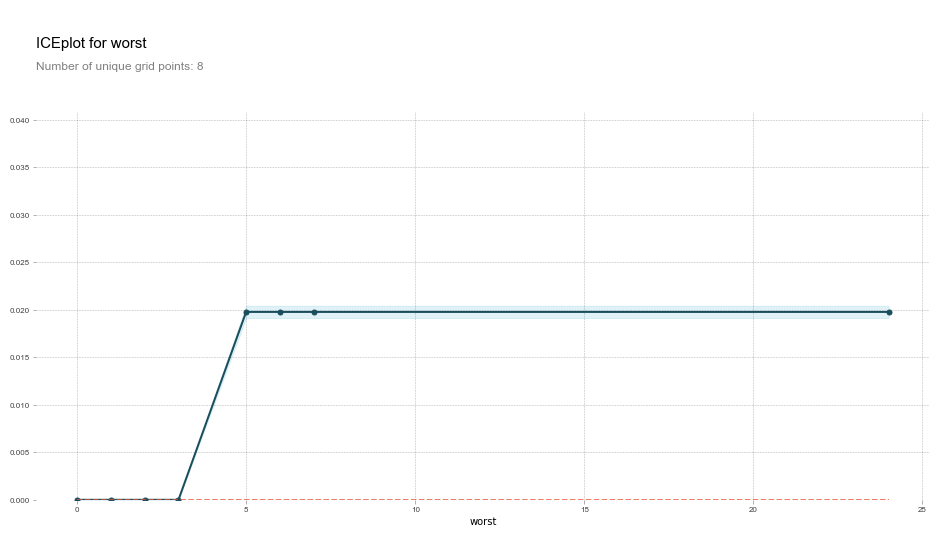

In [124]:
pdpobj = pdp.pdp_isolate(fitrf2, X_test, 'worst')
pdp.pdp_plot(pdpobj, 'worst')
plt.show()

This makes sense, if we see many "worst" in twitters, we expect a potential major drop.

Now, we change some parameters. For example, we set class weight = balanced, because we have a very low base rate.

In [127]:
fitrf3 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1,min_samples_leaf=10,class_weight="balanced"
                               ).fit(X_train_scale, y_train)

In [128]:
yhat_rf3 = fitrf3.predict(X_test_scale)
np.mean(yhat_rf3 != y_test)

0.17307692307692307

In [130]:
prob_rf3=fitrf3.predict_proba(X_test_scale)[:,1]
prob_rank_rf3=np.flip(np.argsort(prob_rf3),0)
np.sum(y_test2[prob_rank_rf3[:20]])/20

0.25

In [131]:
roc_auc_score(y_test,prob_rf3)

0.6107954545454546

It is not necessarily better than the previous result. What we improve is that our top 20 situation contains 5 major drops, but our misclassification rate and AUC score is worse.

## Gradient Descent Boosting

In [133]:
import xgboost as xgb

In [143]:
train_dm = xgb.DMatrix(X_train, y_train)
test_dm = xgb.DMatrix(X_test, y_test)
train_scale_dm=xgb.DMatrix(X_train_scale,y_train)
test_scale_dm=xgb.DMatrix(X_test_scale, y_test)

In [136]:
param = {'objective':'binary:logistic',#What is our loss function? For now, logistic. Would change for multiclass
         'eval_metric':'auc',
         'seed':1
        }
num_round = 100#How many trees?

In [137]:
bst = xgb.train(param, train_dm, num_round)
preds_bst = bst.predict(test_dm)

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
1-accuracy_score(y_test, preds_bst>0.5)

0.15384615384615385

In [140]:
roc_auc_score(y_test,preds_bst)

0.5454545454545454

In [142]:
prob_rank_xgb=np.flip(np.argsort(preds_bst),0)
np.sum(y_test2[prob_rank_xgb[:10]])/10

0.3

The above result does not do scaling. The result is not outstanding.

In [144]:
bst2 = xgb.train(param, train_scale_dm, num_round)
preds_bst2 = bst2.predict(test_scale_dm)

In [145]:
1-accuracy_score(y_test, preds_bst2>0.5)

0.15384615384615385

In [146]:
roc_auc_score(y_test,preds_bst2)

0.5340909090909092

In [148]:
prob_rank_xgb2=np.flip(np.argsort(preds_bst2),0)
np.sum(y_test2[prob_rank_xgb2[:20]])/20

0.2

Scaling does not help that much...

In [149]:
param["eta"]=0.1
cvres = xgb.cv(param, train_scale_dm, 1000)

In [150]:
best_rounds = np.argmax(cvres['test-auc-mean'])
best_rounds

20

In [151]:
bst3 = xgb.train(param, train_scale_dm, best_rounds)
preds_bst3 = bst3.predict(test_scale_dm)
1-accuracy_score(y_test, preds_bst3>0.5)

0.15384615384615385

In [152]:
roc_auc_score(y_test,preds_bst3)

0.6022727272727273

In [154]:
prob_rank_xgb3=np.flip(np.argsort(preds_bst3),0)
np.sum(y_test2[prob_rank_xgb3[:20]])/20

0.2

Slightly better if we do a cv search over best rounds.

In [155]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 

In [156]:
param["n_estimators"]=best_rounds

In [157]:
xgbc = XGBClassifier(
    eta=0.1,#The learning rate: how big are our steps?
    objective='binary:logistic',#What is our loss function? For now, logistic. Would change for multiclas
    eval_metric='auc',
    seed=1,
    n_estimators = best_rounds
)

In [158]:
param_grid1 = {
    'max_depth': [2,4,8,12],
    'scale_pos_weight': [0.3,1,3]
}

In [159]:
grid_search = GridSearchCV(estimator=xgbc, param_grid = param_grid1, scoring='roc_auc', cv=5).fit(X_train_scale, y_train)

In [160]:
grid_search.best_params_

{'max_depth': 2, 'scale_pos_weight': 1}

In [161]:
param2=param.copy()
param2["max_depth"]=2
param2["scale_pos_weight"]=1

In [163]:
cvres2 = xgb.cv(param2, train_scale_dm, 1000)

In [164]:
best_rounds2 = np.argmax(cvres2['test-auc-mean'])
best_rounds2

24

In [165]:
bst4 = xgb.train(param2, train_scale_dm, best_rounds2)
preds_bst4 = bst4.predict(test_scale_dm)
1-accuracy_score(y_test, preds_bst4>0.5)

0.15384615384615385

In [166]:
roc_auc_score(y_test,preds_bst4)

0.5639204545454546

In [169]:
prob_rank_xgb4=np.flip(np.argsort(preds_bst4),0)
np.sum(y_test2[prob_rank_xgb4[:10]])/10

0.2

Unseccussful tuning...

## Naive Bayes 

 We use Gaussian kernel here.

In [15]:
from sklearn.naive_bayes import GaussianNB

In [27]:
gsnb=GaussianNB(priors=np.array([0.1,0.9]))
gsnb.fit(X_train_scale,y_train)
yhat_nb=gsnb.predict(X_test_scale)
np.mean(yhat_nb!=y_test)

0.15384615384615385

In [28]:
prob_nb=gsnb.predict_proba(X_test_scale)[:,1]
prob_rank_gsnb=np.flip(np.argsort(prob_nb),0)
np.sum(y_test2[prob_rank_gsnb[:10]])/10

0.2

In [30]:
roc_auc_score(y_test,prob_nb)

0.5

Kind of like a random guessing... But this is expected because words are definitely not independent.

## Clustering 

In [16]:
from sklearn.decomposition import PCA 

In [43]:
X_raw_scale=scale(X_raw)

To implement, we want to use PCA to do dimensional reduction.

In [44]:
mypca=PCA(random_state=1)
mypca.fit(X_raw_scale)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

In [49]:
np.sum(mypca.explained_variance_ratio_[:35])

0.9001177951323747

It looks like we need 35 features to capture 90% of the information. So we choose 35 dimensions.

We first try k-means.

In [50]:
X_raw_selected=mypca.transform(X_raw_scale)[:,:35]

In [53]:
from sklearn.cluster import KMeans

In [57]:
mykmeans=KMeans(n_clusters=2)
yhat_kmeans=mykmeans.fit_predict(X_raw_selected)

In [58]:
np.mean(yhat_kmeans!=y_raw)

0.1676300578034682

This is actually a decent result because we do not give them any y-train, but because we used PCA here, we cannot interpret the result here...

We also try hierachical clustering.

In [61]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cut_tree

In [62]:
D = euclidean_distances(X_raw_selected)
D = (D + D.T)/2
D = squareform(D)
tree = hierarchy.linkage(D, 'complete')

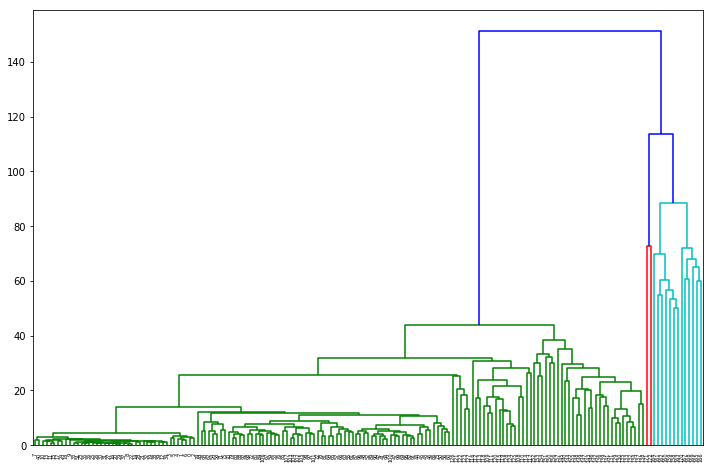

In [66]:
matplotlib.rcParams['figure.figsize'] = (12,8)

plt.figure()
dn = hierarchy.dendrogram(tree)
plt.show()

In [76]:
mycut=cut_tree(tree, n_clusters=2)

In [77]:
pd.crosstab(mycut.reshape(173),y_raw)

y,0,1
row_0,,
0,142,16
1,13,2


It seems like we cannot tell anything with the result.

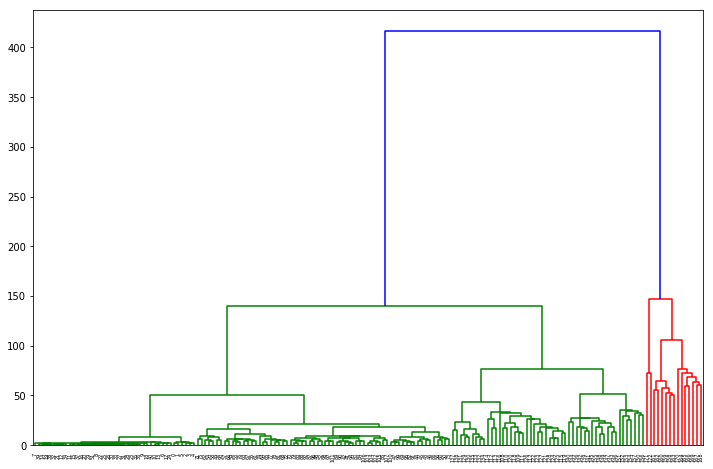

In [71]:
tree2 = hierarchy.linkage(D, 'ward')
plt.figure()
dn2 = hierarchy.dendrogram(tree2)
plt.show()

In [73]:
mycut2=cut_tree(tree2, n_clusters=4)
pd.crosstab(mycut2.reshape(173),y_raw)

y,0,1
row_0,,
0,92,16
1,50,0
2,11,2
3,2,0


In [78]:
16/92

0.17391304347826086

Not a promising result, although we are confident that cluster 1 and 3 does not have 0s, the rate of "1" in cluster 0 is just slightly higher than our base rate.

## SVM 

In [79]:
from sklearn.svm import SVC

In [82]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected=train_test_split(X_raw_selected,
                                                                                      y_raw, 
                                                                                      test_size=0.3, random_state=1)

We first try using linear kernel.

In [84]:
svm_linear=SVC(C=1,kernel="linear",probability=True)
svm_fit_linear = svm_linear.fit(X_train_selected,y_train_selected)
yhat_svm_linear=svm_linear.predict(X_test_selected)
np.mean(yhat_svm_linear!=y_test)

0.19230769230769232

We also try rbf kernel, it performs better.

In [95]:
svm_rbf=SVC(C=1,kernel="rbf",probability=True)
svm_fit_rbf = svm_rbf.fit(X_train_selected,y_train_selected)
yhat_svm_rbf=svm_rbf.predict(X_test_selected)
np.mean(yhat_svm_rbf!=y_test)

0.15384615384615385

In [96]:
svm_rbf2=SVC(C=1,kernel="rbf",probability=True,class_weight="balanced")
svm_fit_rbf2 = svm_rbf2.fit(X_train_selected,y_train_selected)
yhat_svm_rbf2=svm_rbf2.predict(X_test_selected)
np.mean(yhat_svm_rbf2!=y_test)

0.34615384615384615

We tried setting class weight = balanced. It does not help on the misclassification rate.

In [99]:
prob_svm=svm_rbf.predict_proba(X_test_selected)[:,1]
prob_rank_svm=np.flip(np.argsort(prob_svm),0)
print(np.sum(y_test2[prob_rank_svm[:10]])/10)
print(np.sum(y_test2[prob_rank_svm[:20]])/20)

0.3
0.3


In [104]:
roc_auc_score(y_test,prob_svm)

0.7798295454545454

SVM shows its ability to capture major drops. It caputures 3 major drop in the top 10, 6 in top 20. (Remember that we have 8 major drops in 52 test samples.) It also has the highest AUC score.

## KNN 

In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [138]:
myknn=KNeighborsClassifier(n_neighbors=3)
myknn.fit(X_train_selected,y_train_selected)
yhat_knn=myknn.predict(X_test_selected)
np.mean(yhat_knn!=y_test)

0.15384615384615385

In [139]:
prob_knn=myknn.predict_proba(X_test_selected)[:,1]
prob_rank_knn=np.flip(np.argsort(prob_knn),0)
print(np.sum(y_test2[prob_rank_knn[:10]])/10)
print(np.sum(y_test2[prob_rank_knn[:20]])/20)

0.3
0.2


In [140]:
roc_auc_score(y_test,prob_knn)

0.6477272727272727

It seems like KNN does not have ability to predict major drops.

## Summary and some revisit

To make sure our model has ability to interpret, we initially carry analysis without dimensional reduction. However, since our features are much more than our data sample, we want to retry some models with PCA result. Also, we want to summarize the performance of some models that shows the ability to make predictions.

### Revisit of logistic regression 

In [107]:
lmfit3 = LogisticRegression(C=100000).fit(X_train_selected, y_train)

yhat_lm3 = lmfit3.predict(X_test_selected)
np.mean(y_test!=yhat_lm3)

0.23076923076923078

In [109]:
prob_lm3=lmfit3.predict_proba(X_test_selected)[:,1]
prob_rank_lm3=np.flip(np.argsort(prob_lm3),0)
np.sum(y_test2[prob_rank_lm3[:10]])/10

0.1

Hmm, so PCA does not help with logistic regression.

### Revisit of random forest 

In [117]:
fitrf3 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1).fit(X_train_selected, y_train)

In [118]:
yhat_rf3 = fitrf3.predict(X_test_selected)
np.mean(yhat_rf3 != y_test)

0.15384615384615385

In [121]:
prob_rf3=fitrf3.predict_proba(X_test_selected)[:,1]
prob_rank_rf3=np.flip(np.argsort(prob_rf3),0)
np.sum(y_test2[prob_rank_rf3[:10]])/10

0.3

In [122]:
roc_auc_score(y_test,prob_rf3)

0.7059659090909092

PCA does not help with random forest.

### Summary of 3 better models 

From the results above, we think GAM, random forest and svm are the best models in supervised learning. We here want to make a comparison by drawing their ROC curves.

In [127]:
from sklearn.metrics import roc_curve

In [132]:
from scipy.interpolate import spline 

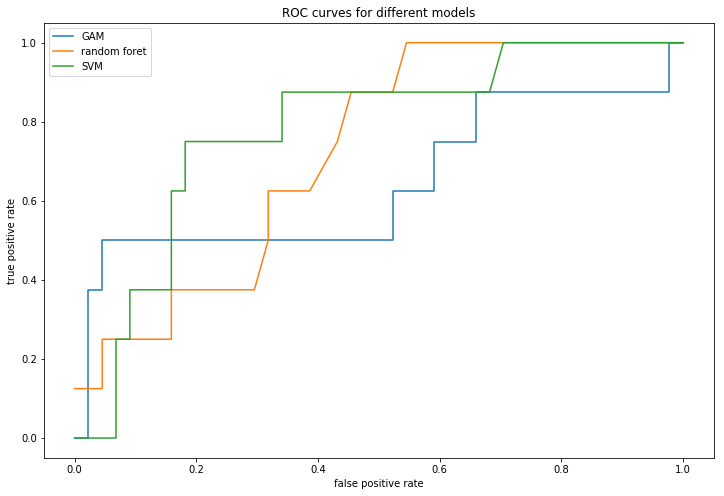

In [136]:
roc_GAM = roc_curve(y_test,prob_gam)
roc_rf=roc_curve(y_test,prob_rf2)
roc_svm=roc_curve(y_test,prob_svm)

line1, = plt.plot(roc_GAM[0],roc_GAM[1])
line2, = plt.plot(roc_rf[0],roc_rf[1])
line3, = plt.plot(roc_svm[0],roc_svm[1])

plt.legend((line1,line2,line3), ('GAM','random foret','SVM'))
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curves for different models")
plt.show()

The curve is wiggly because our test size is relatively small.